In [144]:
using Plots
using JLD2
using Random, Distributions
using StatsBase
using Plots.PlotMeasures

include("/Users/joshua/QTNMLAUG/QuantumInspiredML/LogLoss/RealRealHighDimension.jl");
include("/Users/joshua/QTNMLAUG/QuantumInspiredML/Interpolation/ForecastingMainNew.jl");

# Simple Synthetic

Let's define our first model - a simple (noisy) trendy sine with period $\tau$, trend gradient $m$ and phase offset $\phi$

In [2]:
function GenerateSimpleTrendySine(T::Int = 100; eta::Float64 = 0.1, m::Float64 = 3.0, 
        phi::Float64 = 0.0, tau::Float64=20.0)
    """Generates a noisy trendy sine of length T samples, trend m, and
    corrupted with noisqe of standard deviation 0.1"""
    t = 0:1:(T-1)
    
    signal = sin.((2π .* t ) ./ tau .+ phi) .+ m/T .* t .+ eta * randn(T)

    return signal
    
end

GenerateSimpleTrendySine (generic function with 2 methods)

In [74]:
function GenerateSimpleTrendyDataset(T::Int, num_train::Int, num_test::Int; seed=42)
    """Generate a dataset of simple trendy sines, also return stats on the distribution
    over the varying paramters"""
    Random.seed!(seed)
    num_instances = num_train + num_test
    dataset = Matrix{Float64}(undef, num_instances, T)
    phis = Vector{Float64}(undef, num_instances)
    for i in 1:num_instances
        phi = rand(Uniform(0, 2π)) # randomise the phase offset by sampling its value from a uniform distribution
        phis[i] = phi
        dataset[i, :] = GenerateSimpleTrendySine(; phi=phi)
    end

    # now split into test and train by taking random subsets of the joint dataset
    train_idxs = sample(collect(1:num_instances), num_train, replace=false)
    train_phis = phis[train_idxs]
    test_idxs = setdiff(collect(1:num_instances), train_idxs)
    test_phis = phis[test_idxs]

    X_train = dataset[train_idxs, :]
    y_train = Int.(zeros(num_train))

    X_test = dataset[test_idxs, :]
    y_test = Int.(zeros(num_test))

    # keep track of the distribution of phi across test and train
    stats = Dict(
        :train_phis => train_phis,
        :test_phis => test_phis
    )

    return X_train, y_train, X_test, y_test, stats

end

GenerateSimpleTrendyDataset (generic function with 1 method)

In [100]:
X_train, y_train, X_test, y_test, stats = GenerateSimpleTrendyDataset(100, 300, 200; seed=42);

Let's plot the distribution over the phase offset, $\phi$ for both training and test sets:

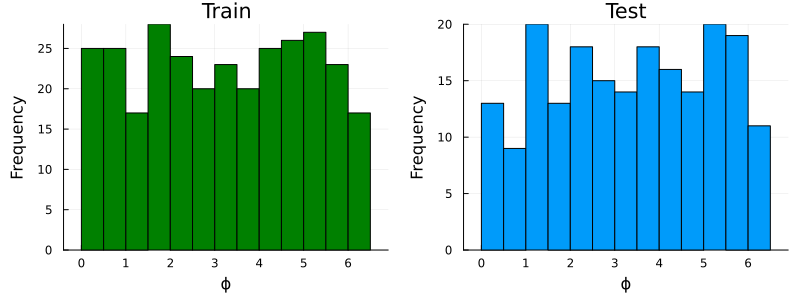

In [101]:
p1 = histogram(stats[:train_phis], bins=20, label="", xlabel="ϕ", c=:green, title="Train", ylabel="Frequency")
p2 = histogram(stats[:test_phis], bins=20, label="", xlabel="ϕ", title="Test", ylabel="Frequency")
plot(p1, p2, size=(800,300), bottom_margin=5mm, left_margin=5mm)

Plot some time series examples from the training set:

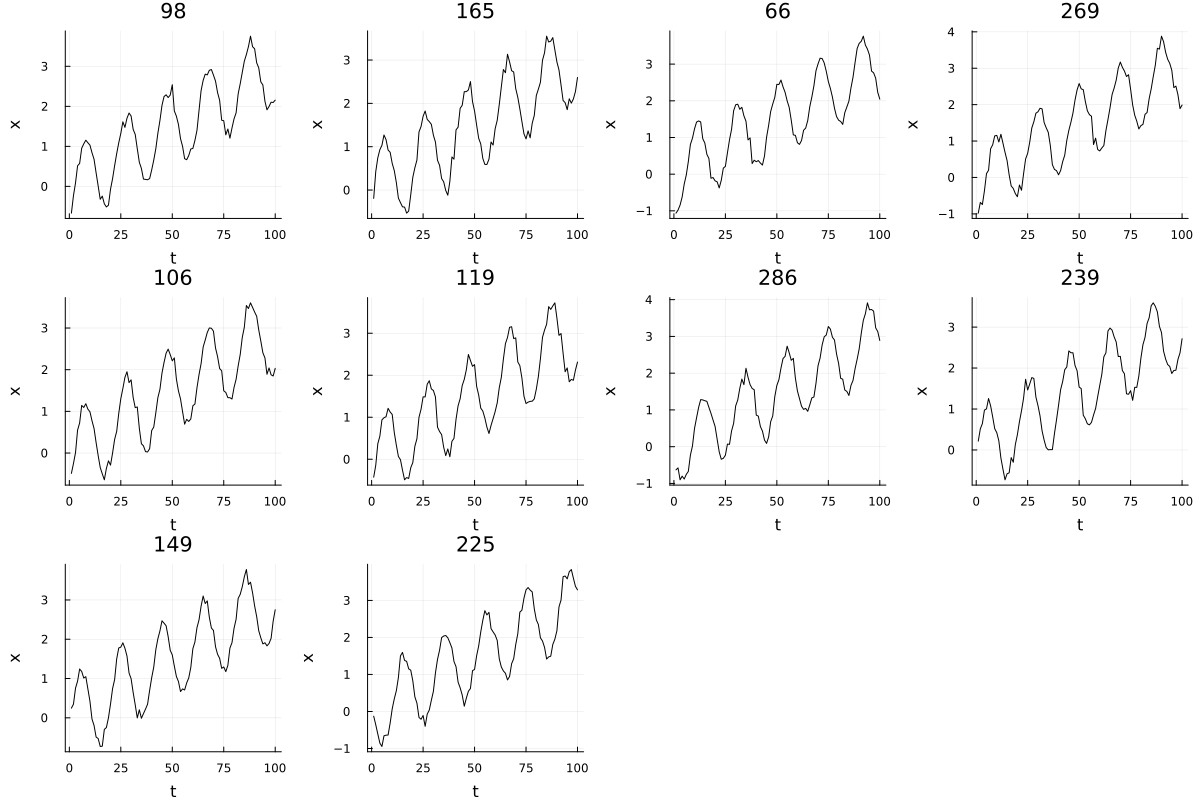

In [130]:
Random.seed!(1234)
plot_idxs = sample(1:300, 10; replace=false);
ps = []
for pidx in plot_idxs
    p = plot(X_train[pidx, :], label ="", c=:black, title=pidx, xlabel="t", ylabel="x")
    push!(ps, p)
end
plot(ps..., size=(1200, 800), left_margin=5mm)

Save the dataset

In [132]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20.jld2", "w") do f
#     f["X_train"] = X_train
#     f["y_train"] = y_train
#     f["X_test"] = X_test
#     f["y_test"] = y_test
#     f["stats"] = stats
# end

Dict{Symbol, Vector{Float64}} with 2 entries:
  :train_phis => [1.70873, 4.73899, 0.698092, 2.07203, 0.927538, 4.21735, 4.098…
  :test_phis  => [6.28121, 4.64596, 4.93887, 3.43421, 5.0982, 1.46261, 1.48448,…

Load in the saved MPS and train/test data.

In [3]:
chis = [5, 10, 15, 20, 40, 60]
svpaths = ["../Data/simple-synthetic/results/legendre_d12_chi$chi.jld2" for chi in chis]

6-element Vector{String}:
 "../Data/simple-synthetic/results/legendre_d12_chi5.jld2"
 "../Data/simple-synthetic/results/legendre_d12_chi10.jld2"
 "../Data/simple-synthetic/results/legendre_d12_chi15.jld2"
 "../Data/simple-synthetic/results/legendre_d12_chi20.jld2"
 "../Data/simple-synthetic/results/legendre_d12_chi40.jld2"
 "../Data/simple-synthetic/results/legendre_d12_chi60.jld2"

In [4]:
function reconstruct_opts(chis)

    setprecision(BigFloat, 128)
    Rdtype = Float64

    verbosity = 0
    test_run = false
    track_cost = false
    #
    encoding = legendre(project=false)
    encode_classes_separately = false
    train_classes_separately = false

    #encoding = Basis("Legendre")
    dtype = encoding.iscomplex ? ComplexF64 : Float64

    opts_all = []
    for chi in chis
        opts=Options(; nsweeps=30, chi_max=chi,  update_iters=1, verbosity=verbosity, dtype=dtype, loss_grad=loss_grad_KLD,
            bbopt=BBOpt("CustomGD"), track_cost=track_cost, eta=0.05, rescale = (false, true), d=12, aux_basis_dim=2, encoding=encoding, 
            encode_classes_separately=encode_classes_separately, train_classes_separately=train_classes_separately, exit_early=false, sigmoid_transform=true)
        push!(opts_all, opts)
    end

    return opts_all
end;

In [5]:
function make_fcs(svpaths::Vector{String}, chis::Vector)
    # takes in saved files and makes forecastables for each
    # assumes same training data for each
    fcs = []
    opts_all = reconstruct_opts(chis)
    for (i, svp) in enumerate(svpaths)
        f = jldopen(svp, "r")
        X_train_scaled = read(f, "X_train_scaled")
        y_train = read(f, "y_train")
        X_test_scaled = read(f, "X_test_scaled")
        y_test = read(f, "y_test");
        mps = read(f, "mps")
        info = read(f, "info")
        close(f)
        opts_rec = opts_all[i]
        fc = load_forecasting_info_variables(mps, permutedims(X_train_scaled), 
            y_train, permutedims(X_test_scaled), y_test, opts_rec);
        push!(fcs, fc)
    end
    return fcs
end

make_fcs (generic function with 1 method)

Load each of the forecastable structs for varying chi max MPSs

In [6]:
all_fcs = make_fcs(svpaths, chis);

UndefVarError: UndefVarError: `legendre` not defined

Let's test it out on a sample from the test set:

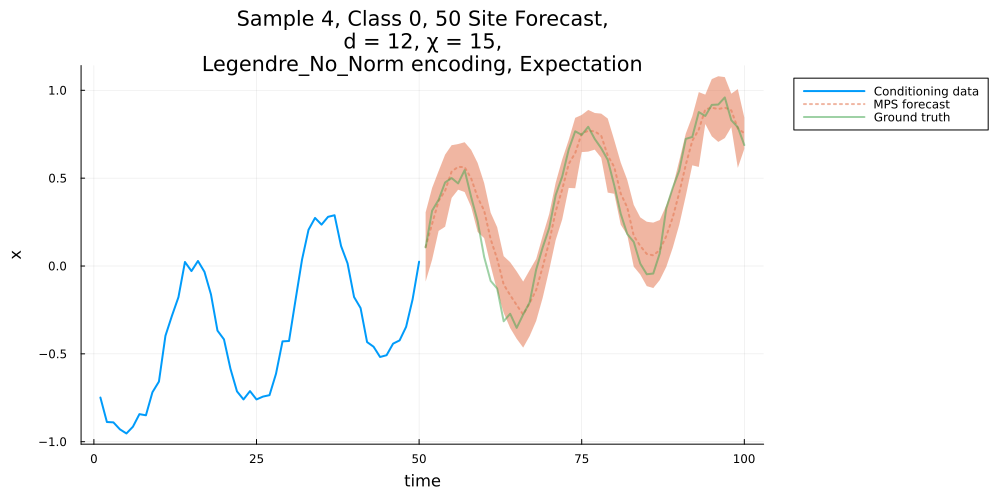

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.457089
  :MSE   => 0.0109603
  :MAPE  => 0.725233
  :MAE   => 0.0844163
  :RMSE  => 0.0109603

In [608]:
forward_interpolate_single_time_series(all_fcs[3], 0, 4, 50, :directMean)

Now, plotting the MAE as a function of number of conditioning points for $\chi = 5$ 

In [453]:
cpts = 1:2:99
scores_5 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_5 = forecast_all(all_fcs[1], :directMean, cpt)
    push!(scores_5, sc_5[1])
end

Get the average MAE across all 200 test samples for each given number of conditioning pts

In [532]:
score_array_5 = hcat(scores_5...);
mean_scores_5 = reverse(mean(score_array_5; dims=1)[1,:]);
median_scores_5 = reverse(median(score_array_5; dims=1)[1,:]);
std_scores_5 = reverse(std(score_array_5; dims=1)[1,:])
# reverse because it is actually the forecast horizon and not the number of conditioning pts

50-element Vector{Float64}:
 0.05634321873231856
 0.05256967364142373
 0.05393573774540313
 0.05408480917874697
 0.05947296556905514
 0.05921036483206099
 0.05442768549643524
 0.05752072346108053
 0.06619773543143488
 0.061552499557233145
 ⋮
 0.09247153959628587
 0.11086286447566658
 0.12971121392314608
 0.14458156473384434
 0.1234539357042971
 0.1293122449622911
 0.10475678372931505
 0.07171642364191154
 0.05144113311432522

Save intermediate results:

In [462]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi5_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores
#    f["std_scores"] = std_scores
# end

50-element Vector{Float64}:
 0.05634321873231856
 0.05256967364142373
 0.05393573774540313
 0.05408480917874697
 0.05947296556905514
 0.05921036483206099
 0.05442768549643524
 0.05752072346108053
 0.06619773543143488
 0.061552499557233145
 ⋮
 0.09247153959628587
 0.11086286447566658
 0.12971121392314608
 0.14458156473384434
 0.1234539357042971
 0.1293122449622911
 0.10475678372931505
 0.07171642364191154
 0.05144113311432522

In [469]:
scores_10 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_10 = forecast_all(all_fcs[2], :directMean, cpt)
    push!(scores_10, sc_10[1])
end

In [524]:
score_array_10 = hcat(scores_10...);
mean_scores_10 = reverse(mean(score_array_10; dims=1)[1,:]);
median_scores_10 = reverse(median(score_array_10; dims=1)[1,:]);
std_scores_10 = reverse(std(score_array_10; dims=1)[1,:])

50-element Vector{Float64}:
 0.16093503251136076
 0.058790020818042264
 0.04438654059502788
 0.04468854639825691
 0.04653069823776552
 0.04825866571679766
 0.04630873790839246
 0.05100346932488212
 0.03994688886137027
 0.04688578938297019
 ⋮
 0.032370504976042797
 0.03456837344909669
 0.033297737433796416
 0.035534213622065595
 0.042176583335458095
 0.04813164521383766
 0.056587388357263194
 0.05699761535355674
 0.045207366611118384

save intermediate results

In [473]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi10_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores_10
#    f["std_scores"] = std_scores_10
# end

50-element Vector{Float64}:
 0.16093503251136076
 0.058790020818042264
 0.04438654059502788
 0.04468854639825691
 0.04653069823776552
 0.04825866571679766
 0.04630873790839246
 0.05100346932488212
 0.03994688886137027
 0.04688578938297019
 ⋮
 0.032370504976042797
 0.03456837344909669
 0.033297737433796416
 0.035534213622065595
 0.042176583335458095
 0.04813164521383766
 0.056587388357263194
 0.05699761535355674
 0.045207366611118384

In [609]:
scores_15 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_15 = forecast_all(all_fcs[3], :directMean, cpt)
    push!(scores_15, sc_15[1])
end

In [610]:
score_array_15 = hcat(scores_15...);
mean_scores_15 = reverse(mean(score_array_15; dims=1)[1,:]);
median_scores_15 = reverse(mean(score_array_15; dims=1)[1,:])
std_scores_15 = reverse(std(score_array_15; dims=1)[1,:])

50-element Vector{Float64}:
 0.1709474164287374
 0.04513598479998773
 0.025491914352911704
 0.023733066514405588
 0.0225258208905405
 0.022307505240114
 0.01879234073736594
 0.018859787973575445
 0.017806437811473334
 0.020744768802377356
 ⋮
 0.013072501469953366
 0.012763725466739718
 0.014958342403365734
 0.015998794669141576
 0.019022727016911902
 0.02183992446790864
 0.021400001829258723
 0.022866357991495233
 0.035654664147643136

In [616]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi15_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores_15
#    f["std_scores"] = std_scores_15
# end

50-element Vector{Float64}:
 0.1709474164287374
 0.04513598479998773
 0.025491914352911704
 0.023733066514405588
 0.0225258208905405
 0.022307505240114
 0.01879234073736594
 0.018859787973575445
 0.017806437811473334
 0.020744768802377356
 ⋮
 0.013072501469953366
 0.012763725466739718
 0.014958342403365734
 0.015998794669141576
 0.019022727016911902
 0.02183992446790864
 0.021400001829258723
 0.022866357991495233
 0.035654664147643136

In [474]:
scores_20 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_20 = forecast_all(all_fcs[4], :directMean, cpt)
    push!(scores_20, sc_20[1])
end

In [529]:
score_array_20 = hcat(scores_20...);
mean_scores_20 = reverse(mean(score_array_20; dims=1)[1,:]);
median_scores_20 = reverse(mean(score_array_20; dims=1)[1,:])
std_scores_20 = reverse(std(score_array_20; dims=1)[1,:])

50-element Vector{Float64}:
 0.18079546689144743
 0.036092486494425
 0.026689764264141432
 0.017442821537200143
 0.014903492823732632
 0.0164423686951252
 0.015612349239262113
 0.015081151331218495
 0.015587025342727831
 0.014827997030897353
 ⋮
 0.009024425679136706
 0.01011857037417986
 0.011205388761065596
 0.011692525141019806
 0.01288682249541405
 0.01312422600966052
 0.015315490034113912
 0.018796376562746218
 0.03374614054975618

save results

In [477]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi20_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores_20
#    f["std_scores"] = std_scores_20
# end

50-element Vector{Float64}:
 0.18079546689144743
 0.036092486494425
 0.026689764264141432
 0.017442821537200143
 0.014903492823732632
 0.0164423686951252
 0.015612349239262113
 0.015081151331218495
 0.015587025342727831
 0.014827997030897353
 ⋮
 0.009024425679136706
 0.01011857037417986
 0.011205388761065596
 0.011692525141019806
 0.01288682249541405
 0.01312422600966052
 0.015315490034113912
 0.018796376562746218
 0.03374614054975618

In [478]:
scores_40 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_40 = forecast_all(all_fcs[5], :directMean, cpt)
    push!(scores_40, sc_40[1])
end

In [530]:
score_array_40 = hcat(scores_40...);
mean_scores_40 = reverse(mean(score_array_40; dims=1)[1,:]);
median_scores_40 = reverse(median(score_array_40; dims=1)[1,:])
std_scores_40 = reverse(std(score_array_40; dims=1)[1,:])

50-element Vector{Float64}:
 0.18273076291031468
 0.03882167056822926
 0.01756061197024471
 0.011312234972990285
 0.00792584655471202
 0.007273206901580824
 0.007129433983651236
 0.006733576036585587
 0.006349333312614284
 0.006236234367831575
 ⋮
 0.00735488290324076
 0.007767358982909327
 0.00859775469319492
 0.009597485386307102
 0.01065037550131997
 0.011265327013256362
 0.012949384283684194
 0.017491529040225412
 0.041558003003629024

Save results

In [483]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi40_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores_40
#    f["std_scores"] = std_scores_40
# end

50-element Vector{Float64}:
 0.18273076291031468
 0.03882167056822926
 0.01756061197024471
 0.011312234972990285
 0.00792584655471202
 0.007273206901580824
 0.007129433983651236
 0.006733576036585587
 0.006349333312614284
 0.006236234367831575
 ⋮
 0.00735488290324076
 0.007767358982909327
 0.00859775469319492
 0.009597485386307102
 0.01065037550131997
 0.011265327013256362
 0.012949384283684194
 0.017491529040225412
 0.041558003003629024

$\chi = 60$:

In [593]:
scores_60 = []
for cpt in cpts
    println("Evaluating $cpt...")
    sc_60 = forecast_all(all_fcs[6], :directMean, cpt)
    push!(scores_60, sc_60[1])
end

In [594]:
score_array_60 = hcat(scores_60...);
mean_scores_60 = reverse(mean(score_array_60; dims=1)[1,:]);
median_scores_60 = reverse(median(score_array_60; dims=1)[1,:])
std_scores_60 = reverse(std(score_array_60; dims=1)[1,:])

50-element Vector{Float64}:
 0.18241378350306786
 0.038114734533707846
 0.015448990806628185
 0.008677659336432206
 0.006460948926905717
 0.006204668898578934
 0.005923647945650878
 0.0054774896453494626
 0.0055239625125432365
 0.005485869985158498
 ⋮
 0.007436554652023271
 0.007700907688130921
 0.008358025625539372
 0.009406512823233596
 0.010439669309224409
 0.011168308184867273
 0.01321703637931146
 0.01773914924557443
 0.03297132250975688

In [595]:
# jldopen("noisy_trendy_sine_eta_01_m_3_tau_20_chi60_results.jld2", "w") do f
#    f["mean_scores"] = mean_scores_60
#    f["std_scores"] = std_scores_60
# end

50-element Vector{Float64}:
 0.18241378350306786
 0.038114734533707846
 0.015448990806628185
 0.008677659336432206
 0.006460948926905717
 0.006204668898578934
 0.005923647945650878
 0.0054774896453494626
 0.0055239625125432365
 0.005485869985158498
 ⋮
 0.007436554652023271
 0.007700907688130921
 0.008358025625539372
 0.009406512823233596
 0.010439669309224409
 0.011168308184867273
 0.01321703637931146
 0.01773914924557443
 0.03297132250975688

Compute the Euclidean 1-Nearest Neighbour interpolations. Use the nearest neighbour from the training set as a naive prediction.

In [518]:
cpts = 1:2:99
nn_sc = Matrix{Float64}(undef, 200, length(cpts))
for (i, cpt) in enumerate(cpts)
    # which sites = sites to interpolate, so starts at cpt + 1
    for j in 1:200
        met, _ = MSE_interpolate(fc, 0, j, collect((cpt+1):100); X_train_scaled=permutedims(X_train_scaled), y_train);
        sc = met[:MAE]
        nn_sc[j, i] = sc
    end
end

In [539]:
mean_nn_sc = mean(nn_sc; dims=1)[1, :];
median_nn_sc = median(nn_sc; dims=1)[1,:];
std_nn_sc = std(nn_sc; dims=1)[1,:];

# Plot Results

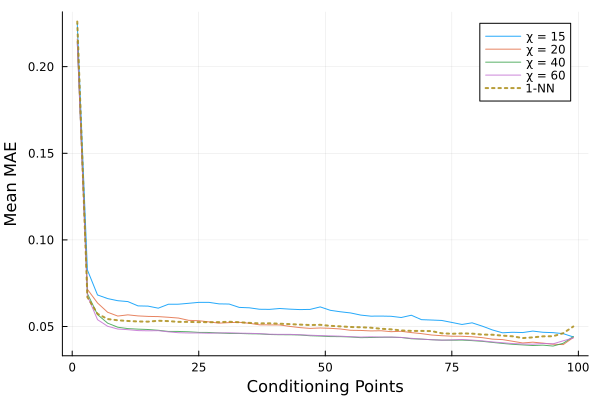

In [657]:
plot(collect(cpts), mean_scores_15, label="χ = 15", 
    xlabel="Conditioning Points", ylabel="Mean MAE", lw=1, alpha=0.85)
plot!(collect(cpts), mean_scores_20, label="χ = 20", lw=1, alpha=0.85)
plot!(collect(cpts), mean_scores_40, label="χ = 40", lw=1, alpha=0.85)
plot!(collect(cpts), mean_scores_60, label="χ = 60", lw=1, alpha=0.85)
plot!(collect(cpts), mean_nn_sc, label="1-NN", ls=:dot, lw=2, alpha=0.85)
#savefig("simple_trendy_sine_meanMAE.svg")

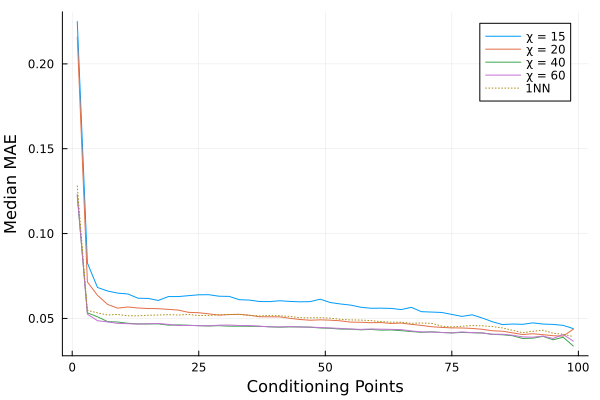

In [632]:
plot(collect(cpts), median_scores_15, label="χ = 15", 
    xlabel="Conditioning Points", ylabel="Median MAE", lw=1)
plot!(collect(cpts), median_scores_20, label="χ = 20", lw=1)
plot!(collect(cpts), median_scores_40, label="χ = 40", lw=1)
plot!(collect(cpts), median_scores_60, label="χ = 60", lw=1)
plot!(collect(cpts), median_nn_sc, label="1NN", ls=:dot, lw=1)

Difference between $\chi = 40$ and $\chi = 60$

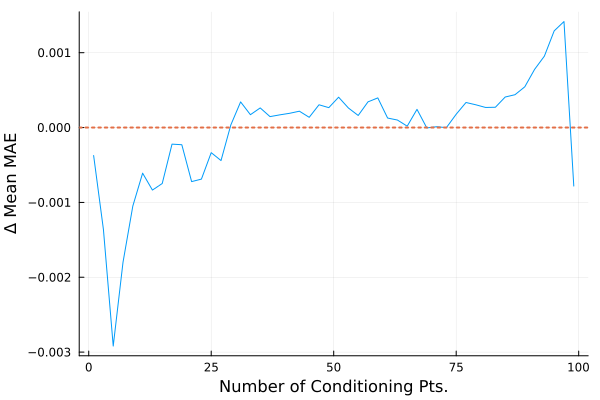

In [630]:
plot(collect(cpts), mean_scores_60 - mean_scores_40, label="", 
    xlabel="Number of Conditioning Pts.", ylabel="Δ Mean MAE")
hline!([0.0], ls=:dot, label="", lw=2)

Positive -> chi = 60 better, Negative -> chi = 40 better. Let's now have a look at the mean MAE on average (for all 
conditioning pts)

In [637]:
mean(mean_scores_40)

0.048406666935730897

In [638]:
mean(mean_scores_60)

0.04837414088297676

Seems as though the performance has saturated by $\chi = 40$ and that $\chi = 60$ yields marginal improvements in performance

# Plot Examples

Here we will pick some random examples for the best performing MPS (on average), at different conditioning window sizes.

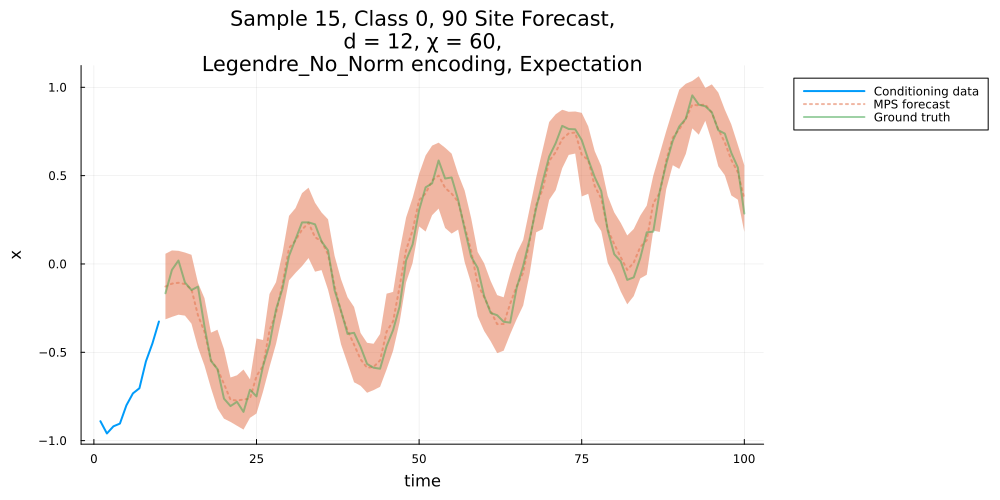

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.255272
  :MSE   => 0.00306255
  :MAPE  => 0.413576
  :MAE   => 0.0421012
  :RMSE  => 0.00306255

In [660]:
Random.seed!(1)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 90, :directMean)
#savefig("simple_trendy_sine_90_site_example.svg")

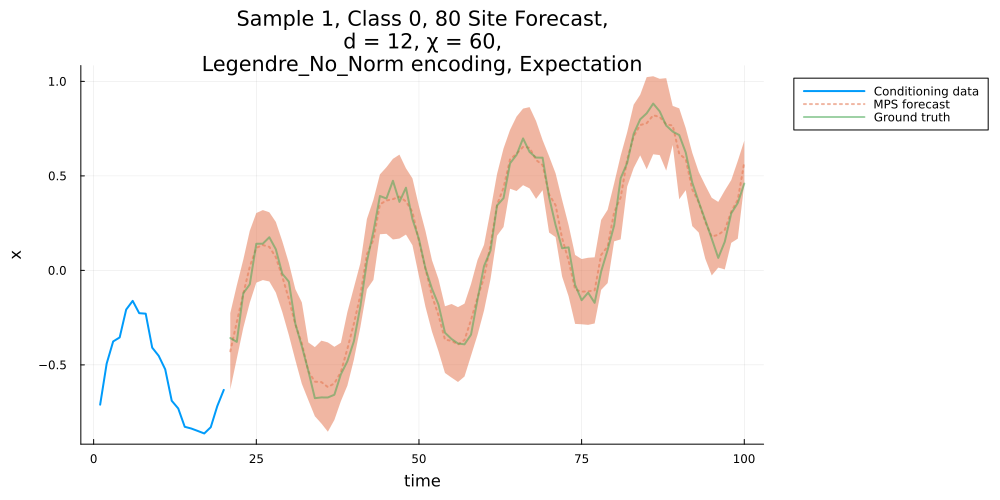

"/Users/joshua/QTNMLAUG/simple_trendy_sine_80_site_example.svg"

In [661]:
Random.seed!(2)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 80, :directMean)
#savefig("simple_trendy_sine_80_site_example.svg")

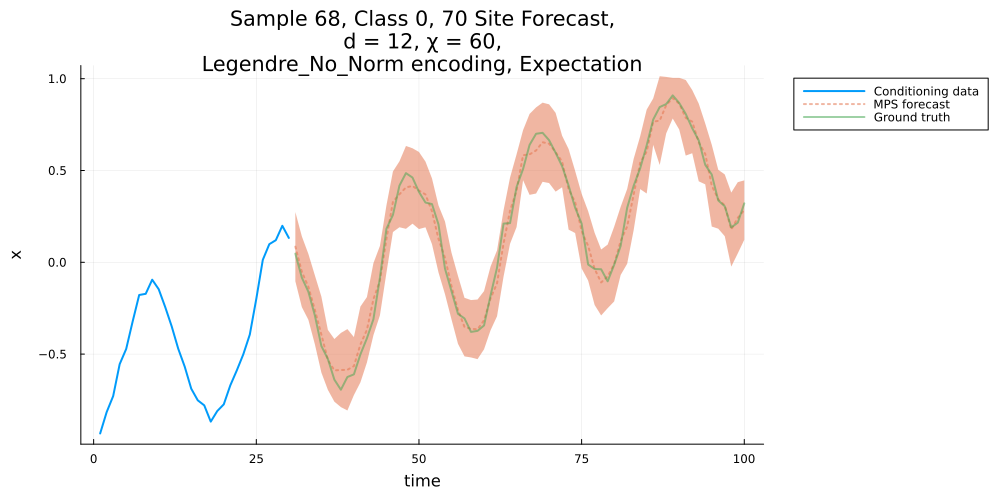

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.222183
  :MSE   => 0.00251256
  :MAPE  => 0.341263
  :MAE   => 0.0411028
  :RMSE  => 0.00251256

In [649]:
Random.seed!(3)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 70, :directMean)

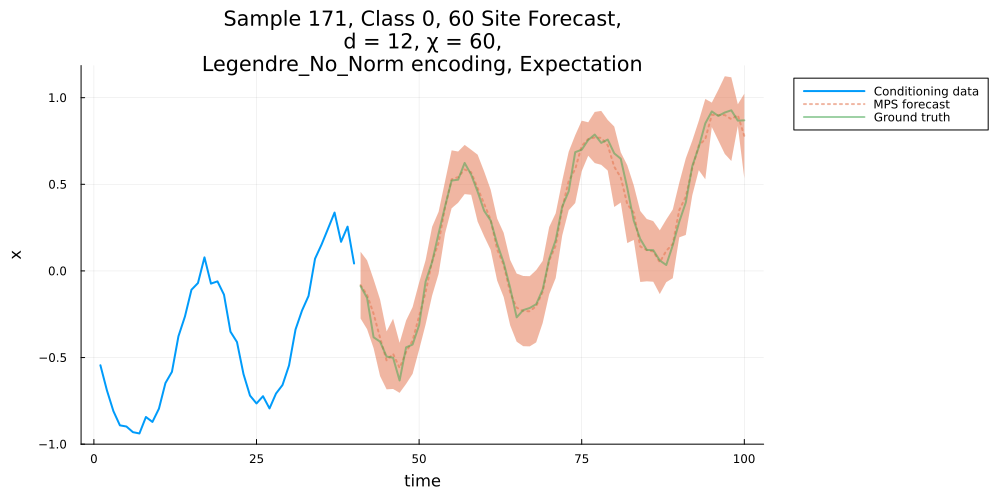

"/Users/joshua/QTNMLAUG/simple_trendy_sine_60_site_example.svg"

In [662]:
Random.seed!(4)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 60, :directMean)
#savefig("simple_trendy_sine_60_site_example.svg")

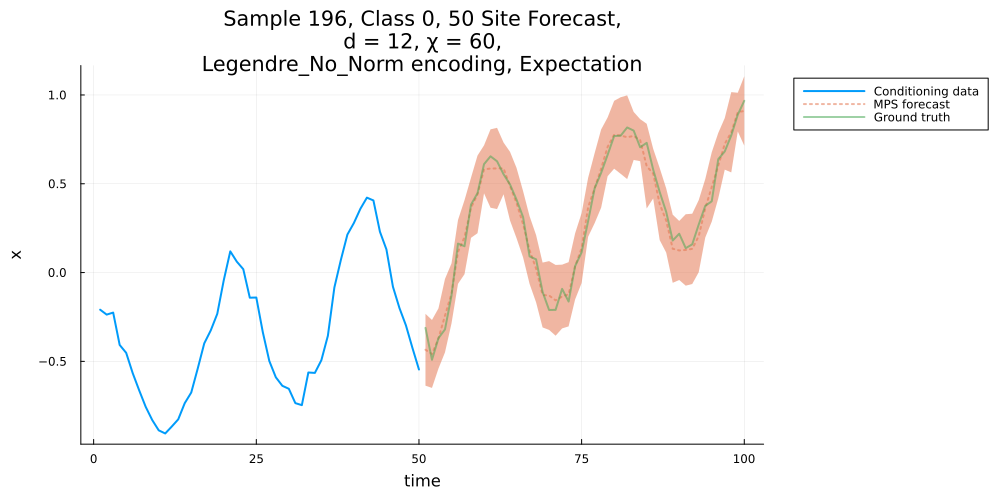

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.161717
  :MSE   => 0.00248877
  :MAPE  => 0.150536
  :MAE   => 0.0403102
  :RMSE  => 0.00248877

In [651]:
Random.seed!(5)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 50, :directMean)

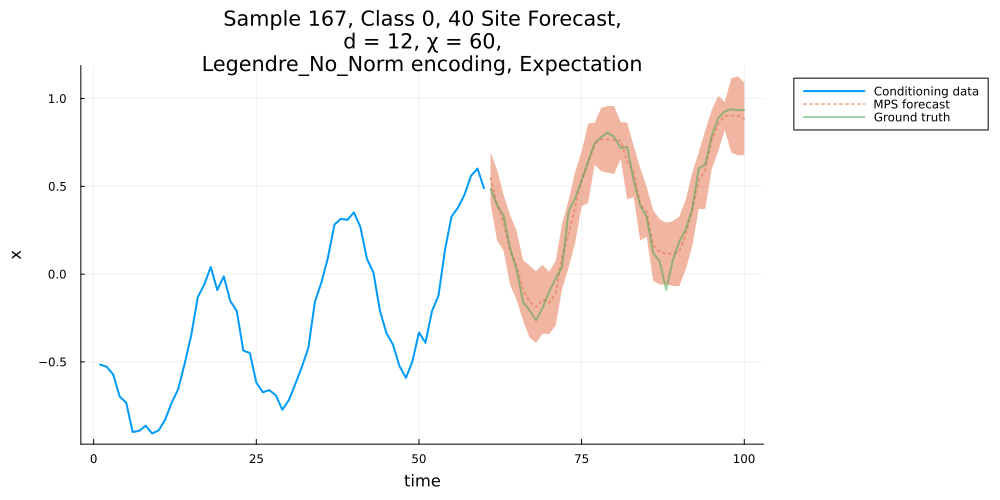

"/Users/joshua/QTNMLAUG/simple_trendy_sine_40_site_example.svg"

In [663]:
Random.seed!(6)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 40, :directMean)
savefig("simple_trendy_sine_40_site_example.svg")

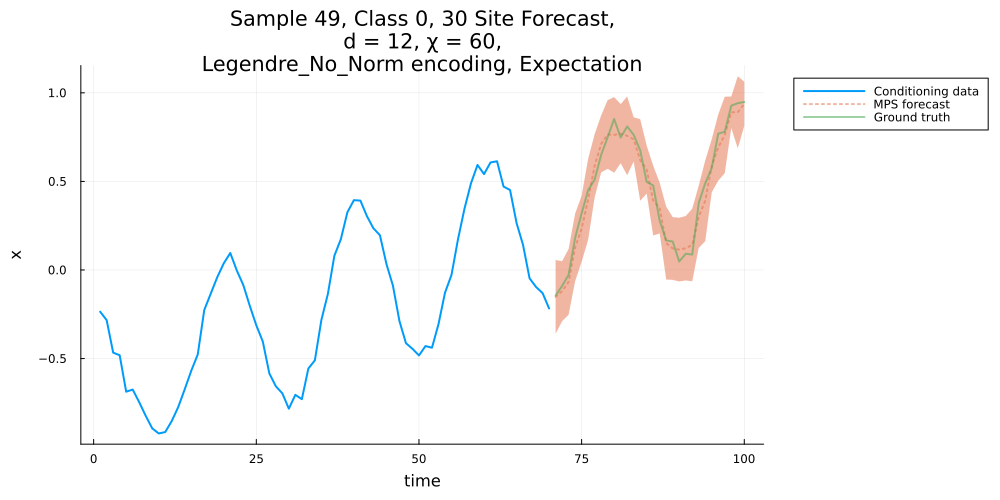

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.192647
  :MSE   => 0.00315945
  :MAPE  => 0.235241
  :MAE   => 0.0495777
  :RMSE  => 0.00315945

In [653]:
Random.seed!(7)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 30, :directMean)

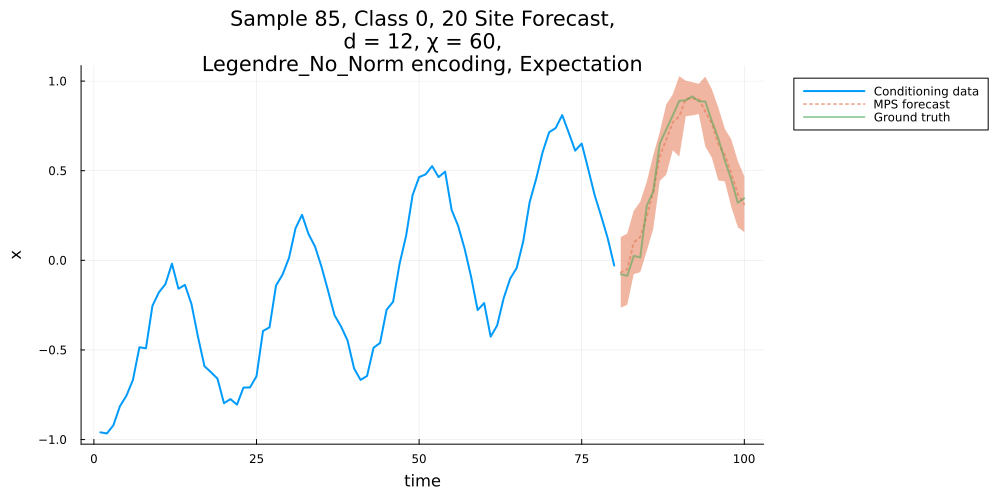

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.228248
  :MSE   => 0.00258751
  :MAPE  => 0.583432
  :MAE   => 0.0420093
  :RMSE  => 0.00258751

In [654]:
Random.seed!(8)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 20, :directMean)

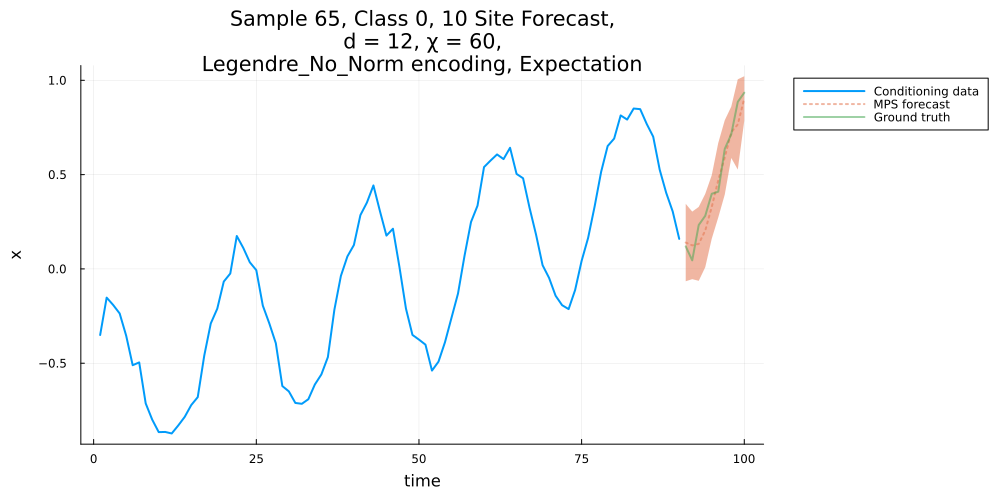

Dict{Symbol, Float64} with 5 entries:
  :SMAPE => 0.255507
  :MSE   => 0.0048727
  :MAPE  => 0.319866
  :MAE   => 0.0614244
  :RMSE  => 0.0048727

In [655]:
Random.seed!(9)
forward_interpolate_single_time_series(all_fcs[6], 0, rand(1:200), 10, :directMean)